# Projection Methods - Lucas Asset Pricing Model

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook, I use a projection method to solve the Lucas Asset Pricing Model. This notebook is heavily inspired by an assignment from the LSE macro tools summer school taught by [Wouter den Haan](http://www.wouterdenhaan.com/summercourse_essentials.html). The original code from the assignment was written in Matlab. This is a Python version of the code with some improvements.

In [1]:
import numpy as np
from scipy import optimize as opt
from numba import jit

# Graphics imports
import matplotlib.pyplot as plt
import seaborn as sns  # Better quality figures
%matplotlib notebook
# Displays figures inside the notebook
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)  # Sets the size of the figures in the notebook

from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## Model

The solution of the model can be formulated as the following system of equations:
$$
\begin{align}
p_t &= \beta \mathbb{E}_t \left[ \left( \frac{c_{t+1}}{c_t} \right)^{-\gamma} (d_{t+1} + p_{t+1}) \right]
\\
c_t &= d_t
\\
d_t &= \mu_d + \rho_d d_{t-1} + \varepsilon_t
\\
\varepsilon_t &\sim \mathcal{N}(0,\sigma^2)
\end{align}
$$

In this model, the only state variable is $d_t$. We can combine the first three equations in order to simplify the problem:
$$
p_t = \beta \mathbb{E}_t \left[ \left( \frac{\mu_d + \rho_d d_{t} + \varepsilon_{t+1}}{d_t} \right)^{-\gamma} (\mu_d + \rho_d d_{t} + \varepsilon_{t+1} + p_{t+1}) \right]
$$


## Asset Pricing Solution

The idea behind projection methods is to find a polynomial which approximates the policy function. In this problem, we want to approximate the price policy function mapping the state variable $d_t$ to the price of the asset $p_t$ with a nth-order polynomial:
$$
p_t = p_t(d_t) \approx \sum_{i=0}^n a_i d_t^i
$$

In [2]:
# @jit
def p_poly(coef,d):
    
    # polyval takes coefficients in decreasing order
    p = np.polyval(coef,d)
    # 
#     p = coef[0]*d**5 + coef[1]*d**4 + coef[2]*d**3 + coef[3]*d**2 + coef[4]*d + coef[5]
    return p

#### Parameters

In [3]:
# Setting up a dictionary of model parameters
# Using a dict makes the operation of passing different sets of parameters to a function quite easy
# The inconvenience is that we'll have to extract the necessary parameters inside every function

params = {'beta':0.9,'gamma':3.,'mu_d':0.1,'rho_d':0.9,'sigma':0.1}

# Extracting and assigning values to the global parameters from the dict
beta = params['beta']
gamma = params['gamma']
mu_d = params['mu_d']
rho_d = params['rho_d']
sigma = params['sigma']

#### Grid

In this model, $d_t$ is the only state variable. In order to solve our problem using a projection method, we have to construct a grid for $d_t$:

In [4]:
d_mean = mu_d/(1-rho_d)                   # AR(1) mean
d_std  = sigma/np.sqrt((1-rho_d**2))      # AR(1) std
d_low  = d_mean - 3*d_std  # grid lower bound               
d_high = d_mean + 3*d_std  # grid upper bound
d_numb = 10                # Number of grid points
d_grid = np.linspace(d_low,d_high,d_numb)

#### Numerical Integration

The idea here is to approximate the expectation term using numerical integration and in particular Gauss-Hermite quadrature. 

We have for $x \sim \mathcal{N}(\mu,\sigma^2)$:
$$
\mathbb{E}(h(x)) \approx \sum_{i=1}^{\textit{gh}} \left(\frac{\omega_i}{\sqrt{\pi}} h (\mu + \sigma \sqrt{2}\zeta_i) \right)
$$
where $\omega_i$ and $\zeta_i$ are the Gauss-Hermite weights and nodes.

Below, we set the GH weights and nodes:

In [6]:
gh = {}  

gh['size'] = 5  # Number of nodes and weights for the Gauss-Hermite quadrature

# Use the hermgauss function to get the nodes and weights for the Gauss-Hermite quadrature
gh['nodes'], gh['weights'] = np.polynomial.hermite.hermgauss(gh['size'])

In [7]:
# @jit
def errfunc(coef,params,grid,quad):
    # Extracting parameters from dict
    beta = params['beta']
    gamma = params['gamma']
    mu_d = params['mu_d']
    rho_d = params['rho_d']
    sigma = params['sigma']
    
    # Extracting parameters for the quadrature
    q_size = quad['size']
    q_nodes = quad['nodes']
    q_weights = quad['weights']
    
    # Initialize arrays
    # Method size returns the number of elements in the array. Since the array is flat its the same as the length
    lhs  = np.zeros(grid.size)  
    rhs  = np.zeros(grid.size)
    temp = np.zeros(q_size)
    
    for i in range(grid.size):
        d = grid[i]
        
        lhs[i] = p_poly(coef,d)  # Computes the price for d_i
        
        for j in range(q_size):  # Computes the RHS for every realisation of the shock
            eps = q_nodes[j]
            d_new = mu_d + rho_d * d + sigma * np.sqrt(2) * eps
            p_new = p_poly(coef,d_new)
            temp[j] = (q_weights[j] / np.sqrt(np.pi)) * beta * (d_new / d) ** (-gamma) * (d_new + p_new)
            
        rhs[i] = np.sum(temp)  # Expectation step
    
    ssr = np.linalg.norm(lhs - rhs,ord=2)  # takes the L2 norm of the errors (Eucledian norm)
    
    return ssr            

Now that we have everything in place, we can pass the error function to a minimization routine in order to solve for the coefficients that minimize the squared sume of Euler errors:

In [8]:
poly_order = 5  # Order of the approximating polynomial

coef_in = np.zeros((poly_order+1))  # Set initial values for the coefficients

# Find solution by minimizing the errors on the grid
# I pass the output of the first minimization to the 2nd minimization as initial values
# to have a better chance of hitting the global minimizer

results = opt.minimize(errfunc,coef_in,args=(params,d_grid,gh),method='Nelder-Mead',tol=0.0000001,options={'maxiter':1000000})
coef_out = results.x
results = opt.minimize(errfunc,coef_out,args=(params,d_grid,gh),method='Nelder-Mead',tol=0.0000001,options={'maxiter':1000000})
coef_out = results.x
print(coef_out)

[ 0.31009413 -1.76824169  3.89741216  5.99221532  2.14293414 -0.24337511]


<IPython.core.display.Javascript object>


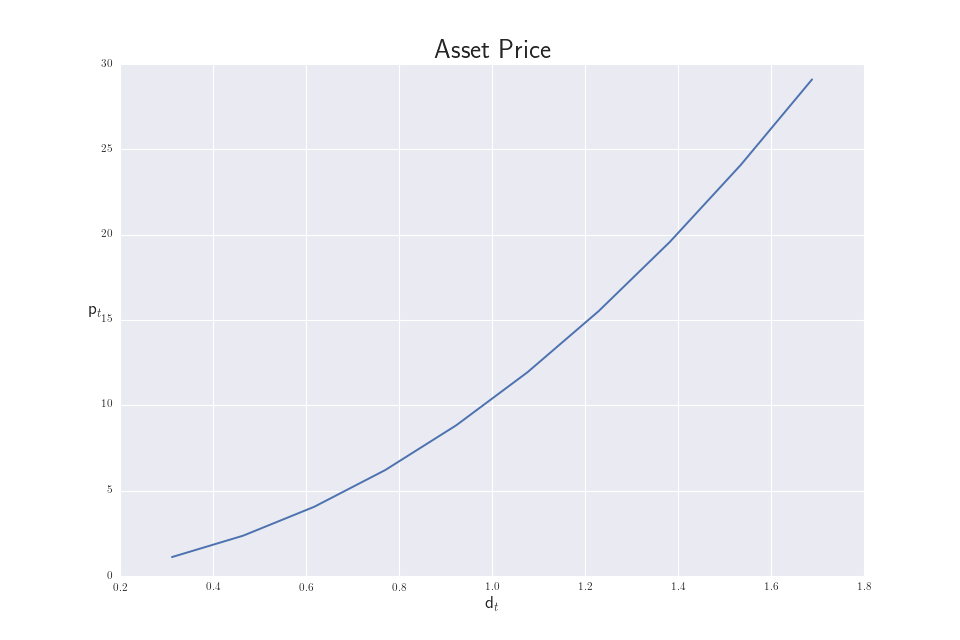

In [10]:
fig1 = plt.figure(1)
plt.plot(d_grid,p_poly(coef_out,d_grid))
plt.title('Asset Price',fontsize=24)
plt.xlabel(r'd_{t}', fontsize=16)
plt.ylabel(r'p_{t}', fontsize=16,rotation=0)

## Measuring the Risk Premium

The risk-free rate and the expected return are given by the following two equations:

$$
\begin{align}
1 &= \left(1 + r_t^f \right) \beta \mathbb{E}_t \left[ \left( \frac{c_{t+1}}{c_t} \right)^{-\gamma}  \right]
\\
r_{t+1} &= \frac{d_{t+1} + p_{t+1}}{p_t} - 1
\end{align}
$$

We define the risk premium as the difference between the expected return and the risk-free rate:

$$
x_t = \mathbb{E}(r_{t+1}) - r_t^f
$$

The objective here is to approximate $x_t$ using the nth order polynomial:  $x_t(d_t) = \sum_{i=0}^n b_i d_t^i$

In order to do that, an option would be to calculate $r_t^f$, $\mathbb{E}(r_{t+1})$ and $x_t$ in every grid point and then run a regression (projection).

We will write one function that calculates all three.

In [30]:
def riskprem(coef,params,grid,quad):
    # Extracting parameters from dict
    beta = params['beta']
    gamma = params['gamma']
    mu_d = params['mu_d']
    rho_d = params['rho_d']
    sigma = params['sigma']
    
    # Extracting parameters for the quadrature
    q_size = quad['size']
    q_nodes = quad['nodes']
    q_weights = quad['weights']
    
    # Initialize arrays
    # Method size returns the number of elements in the array. Since the array is flat its the same as the length
    xr  = np.zeros(grid.size)  # expected return array
    rfr = np.zeros(grid.size)  # risk free rate array
    temp1 = np.zeros(q_size)  # array to store xr for every eps before taking expectations
    temp2 = np.zeros(q_size)  # array to store xr for every eps before taking expectations
    
    # Computing expected return and risk free rate
    for i in range(grid.size):
        d = grid[i]
        
        p = p_poly(coef,d)  # Computes the price for d_i
        
        for j in range(q_size):  
            eps = q_nodes[j]
            d_new = mu_d + rho_d * d + sigma * np.sqrt(2) * eps
            p_new = p_poly(coef,d_new)
            # Computes the gross rate of return for every realisation of the shock
            temp1[j] = (q_weights[j] / np.sqrt(np.pi)) * ((d_new + p_new) / p)
            # Computes the gross risk free rate for every realisation of the shock
            temp2[j] = (q_weights[j] / np.sqrt(np.pi)) * (beta * (d_new / d) ** (-gamma))
        
        xr[i] = np.sum(temp1) - 1
        rfr[i] = 1 / np.sum(temp2) - 1
    rp = xr - rfr
        
    
    return xr, rfr, rp


In [31]:
xr, rfr, rp = riskprem(coef_out,params,d_grid,gh)

<IPython.core.display.Javascript object>


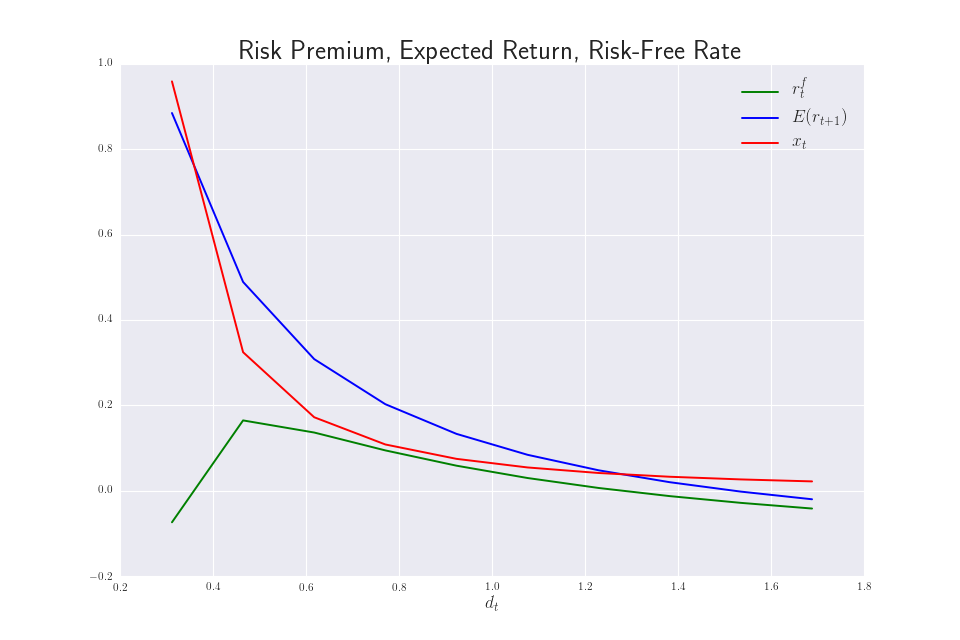

In [32]:
fig2 = plt.figure(2)
plt.plot(d_grid, rfr,'-g',label=r'$r_t^f$')
plt.plot(d_grid, xr,'-b',label=r'$\mathbb{E}(r_{t+1})$')
plt.plot(d_grid, rp,'-r',label=r'$x_t$')
plt.title('Risk Premium, Expected Return, Risk-Free Rate',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.xlabel(r'$d_{t}$', fontsize=16)